In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import os

import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

### Import dataset and put into dataloader

In [2]:
# import CIFAR-10 dataset into trainset, testset
# load in to trainloader, testloader

# color dataset
transform_color = transforms.Compose([
        transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))
    ])

batchSize = 32

trainset_color = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_color)
trainloader_color = torch.utils.data.DataLoader(trainset_color, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset_color = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_color)
testloader_color = torch.utils.data.DataLoader(testset_color, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

Files already downloaded and verified
Files already downloaded and verified
cuda:0


### Pre-processing: Convert all rgb images to gray images

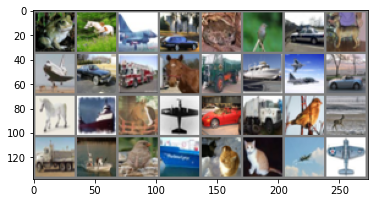

torch.Size([32, 3, 32, 32])


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig('plot/result_miniBatch_'+str(batchSize)+'.png', dpi=1000)
    plt.show()

# get some random training images
dataiter = iter(trainloader_color)
images_color, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images_color))

# show dataiter shape
print(images_color.shape)

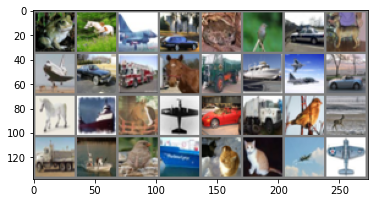

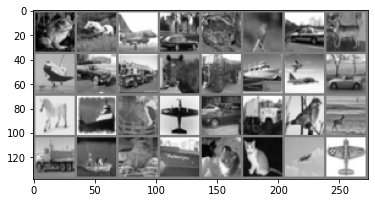

images_gray shape:  torch.Size([32, 1, 32, 32])


In [4]:
# function to convert a rgb_img to gray_img
def rgb2gray(img):
    rgb_img = img.transpose(1,2,0)
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    return gray_img

# function to convert a batch of rgb images to gray images
def rgb2gray_batch(images):
    rgb_images = np.array(images)    
    
    gray_images = []
    for i in range(rgb_images.shape[0]):
        img = rgb_images[i]
        gray_img = rgb2gray(img)
        gray_images.append(gray_img)
    
    gray_images = np.array(gray_images)
    gray_images = torch.from_numpy(gray_images)
    return gray_images
        
images_gray = rgb2gray_batch(images_color)

# show images
images_gray = images_gray.reshape(batchSize,1,32,32)

imshow(torchvision.utils.make_grid(images_color))
imshow(torchvision.utils.make_grid(images_gray))
print("images_gray shape: ", images_gray.shape)

### Define the Auto-Encoder network
The shape of a convolutional layer depends on the supplied values of kernel_size, input_shape, padding, and stride. Let's define a few variables:

K - the number of filters in the convolutional layer\
F - the height and width of the convolutional filters\
S - the stride of the convolution\
P - the padding\
W_in - the width/height (square) of the previous layer

Notice that K = out_channels, F = kernel_size, and S = stride. Likewise, W_in is the first and second value of the input_shape tuple.

The depth of the convolutional layer will always equal the number of filters K.

The spatial dimensions of a convolutional layer can be calculated as: (W_in−F+2P)/S+1

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1,3, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(3,6,kernel_size=3, padding=1),
            nn.ReLU(True))
        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(6,3,kernel_size=3, padding=1),
        )
            
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Define the loss function and optimizer

In [6]:
# define loss function and optimizer
model = Autoencoder().to(device)
print("is cuda: ", next(model.parameters()).is_cuda)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

model_path = "./saved_model/AutoEncoder_batch_"+str(batchSize)+ ".pt"
if os.path.exists(model_path):
    print("Continue training from the saved model")
    mlp_net.load_state_dict(torch.load(model_path))

is cuda:  True


### Tensorboard to save all training output logs

In [7]:
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter("./runs/AutoEncoder_batch_"+str(batchSize)+"/")

### Train the network

In [8]:
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    num_training = 0
    for i, data_color in enumerate(trainloader_color, 0):
        # get the inputs; data is a list of [inputs, labels]
        images_color, labels_color = data_color
        images_gray = rgb2gray_batch(images_color)
        
        # put data in gpu/cpu
        images_color = images_color.to(device)
        images_gray = images_gray.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        # Size - images_gray: [batchSize,1,32,32]
        images_gray = images_gray.reshape(images_color.shape[0],1,32,32)
        outputs = model(images_gray)
    
        # Backward
        # Size - images_color: [batchSize,3,32,32]
        # Size - outputs: [batchSize,3,32,32]
#         print("images_color: ", images_color.shape)
#         print("outputs: ", outputs.shape)
        loss = criterion(outputs, images_color)
        loss.backward()
        optimizer.step()

        # print output statistics
        running_loss += loss.item()
        
        j = 200
        if i % j == (j-1):     # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / j))
            
            writer.add_scalar('Loss/train', running_loss/j, len(trainset_color)*epoch + i)
            running_loss = 0.0

writer.flush()
writer.close()
print('Finished Training')

[1,   200] loss: 0.113
[1,   400] loss: 0.037
[1,   600] loss: 0.031
[1,   800] loss: 0.029
[1,  1000] loss: 0.028
[1,  1200] loss: 0.027
[1,  1400] loss: 0.026
[2,   200] loss: 0.025
[2,   400] loss: 0.025
[2,   600] loss: 0.025
[2,   800] loss: 0.024
[2,  1000] loss: 0.025
[2,  1200] loss: 0.025
[2,  1400] loss: 0.024
[3,   200] loss: 0.025
[3,   400] loss: 0.024
[3,   600] loss: 0.023
[3,   800] loss: 0.024
[3,  1000] loss: 0.024
[3,  1200] loss: 0.024
[3,  1400] loss: 0.024
[4,   200] loss: 0.024
[4,   400] loss: 0.024
[4,   600] loss: 0.024
[4,   800] loss: 0.023
[4,  1000] loss: 0.024
[4,  1200] loss: 0.024
[4,  1400] loss: 0.023
[5,   200] loss: 0.024
[5,   400] loss: 0.023
[5,   600] loss: 0.023
[5,   800] loss: 0.023
[5,  1000] loss: 0.023
[5,  1200] loss: 0.023
[5,  1400] loss: 0.024
[6,   200] loss: 0.023
[6,   400] loss: 0.024
[6,   600] loss: 0.024
[6,   800] loss: 0.024
[6,  1000] loss: 0.023
[6,  1200] loss: 0.024
[6,  1400] loss: 0.023
[7,   200] loss: 0.023
[7,   400] 

### Inference on train dataset

images_color:  torch.Size([32, 3, 32, 32])


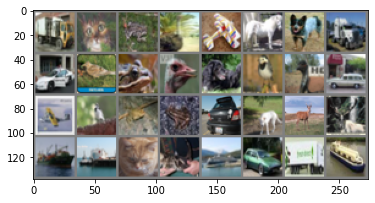

images_gray:  torch.Size([32, 32, 32])


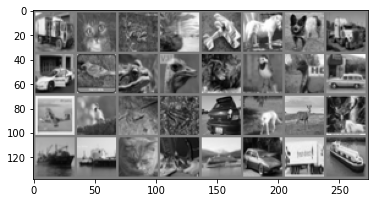

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])


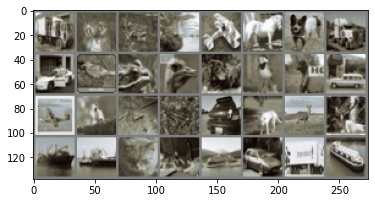

In [9]:
# get some random training images
dataiter = iter(trainloader_color)
images_color, labels_color = dataiter.next()
print("images_color: ", images_color.shape)
# show images
images_color_show = images_color.reshape(batchSize,3,32,32)
imshow(torchvision.utils.make_grid(images_color_show.detach()))

images_gray = rgb2gray_batch(images_color)
print("images_gray: ", images_gray.shape)
# show images
images_gray = images_gray.reshape(batchSize,1,32,32)
imshow(torchvision.utils.make_grid(images_gray.detach()))

# run inference on the network
# oututs [4,3072]
images_gray = images_gray.to(device)
outputs = model(images_gray)
print(outputs.shape)

images_color = outputs.reshape(batchSize,3,32,32)
print(images_color.shape)

images_color = images_color.to("cpu")
imshow(torchvision.utils.make_grid(images_color.detach()))


### Save the model

In [10]:
if not os.path.exists('./saved_model'):
    os.makedirs('./saved_model')

    
torch.save(model.state_dict(), model_path)

### Inference on test dataset

images_color:  torch.Size([32, 3, 32, 32])


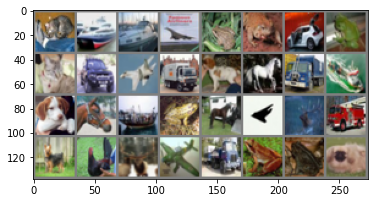

images_gray:  torch.Size([32, 32, 32])


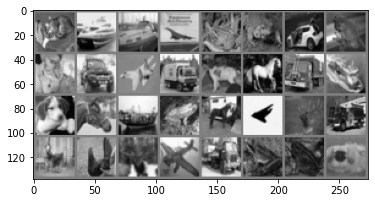

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 32, 32])


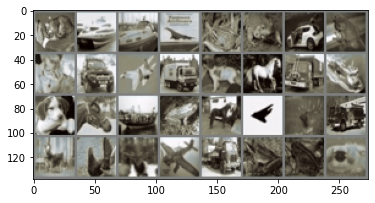

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


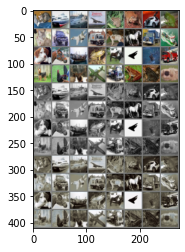

In [11]:
# get some random training images
dataiter = iter(testloader_color)
images_color, labels_color = dataiter.next()
print("images_color: ", images_color.shape)
# show images
images_color_show = images_color.reshape(batchSize,3,32,32)
imshow(torchvision.utils.make_grid(images_color_show.detach()))

images_gray = rgb2gray_batch(images_color)
print("images_gray: ", images_gray.shape)
# show images
images_gray = images_gray.reshape(batchSize,1,32,32)
imshow(torchvision.utils.make_grid(images_gray.detach()))

# run inference on the network
images_gray = images_gray.to(device)
outputs = model(images_gray)
outputs_color = outputs.reshape(batchSize,3,32,32)
print(outputs_color.shape)

outputs_color = outputs.to("cpu")
imshow(torchvision.utils.make_grid(outputs_color.detach()))

images_gray = images_gray.to("cpu")
images_gray = torch.cat((images_gray, images_gray, images_gray), 1)

final_result_display = torch.cat((images_color_show, images_gray, outputs_color), 0)
imshow(torchvision.utils.make_grid(final_result_display.detach()))